#  Neural network in adult income prediction

     the universal workflow of machine learning.

## 1.1 Introduction

Neural network(NN) is widely used in solving various problems, such as computer vision and speech recognition. Unlike many other machine learning algorithms, NN does not restrict input feature distributions and can learn features from layers of neurons. Additionally, NN percepts input data into multiple layers and neurons and learn the inherent patterns. Hence, we can ease ourselves from tedious feature engineering. One of the major advantages compared to many other machine learning algorithms is that NN could make continuous performance improvements when the data size becomes bigger. Although many machine learning methods, such as random forest, are widely used in classification problems, NN could be a better solution for the rapid growth of new data.

This coursework studies how NN could be adopted in classification tasks to determine whether a person's income is over 50 thousand USD annually based on the "Census Income" dataset. The dataset, also named "Adult Data Set" is extracted from the 1994 Census database. The "Adult Data Set" contains 14 attributes, including both continuous and categorical data types. Generally, a person's income comes from the salary of his work. The census data attributes such as age, workclass, education level and the number of years of education, marital status, occupation, relationship(role in the family), working hours per week, capital gain or loss, race, sex, the native-country covered most relevant information relating to income level. These relationships will be further explored in our data exploration part. Next, we will discuss methodology including measure of success, evaluation protocol, etc. After that, we will prepare the data set to build various NN models and summary the results. In the following section, we will discuss our results and conclude the findings.

## 1.2 Data exploration 

Data exploration not only helps us to understand each variable and its associations but only allows us to evaluate the appropriate performance metrics and the suitable approach for model evaluation.

### 1.2.1 Import libraries and define fuctions

In [1]:
# import all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier 
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils # to generate random seed
import keras_tuner as kt


In [2]:
#define a function to visualize model performance

# smooth the line by discounting current and previous points
def smooth_points(points, factor=0.6):
    smoothed_points=[]
    for point in points:
        if smoothed_points: # an empty list is false
            p = smoothed_points[-1] # the last appended point
            smoothed_points.append(p*factor + point*(1-factor))
        else:
            smoothed_points.append(point) # append the point when the list is empty
    return smoothed_points
"""
code from course slides DSM150-2022-OCT, Topic 3: Getting started with 
neural networks (part 2), 3.609 More epochs, validation log, plotting,
smoothing. 
https://learn.london.ac.uk/mod/page/view.php?id=96938
"""

def performance_curve(trained_model, p=0):
    """
    Make a line plot.
    
    To plot the performance data of a trained_model from both training and 
    validation data set against each epoches. 
    
    Parameters
    ----------
    trained_model:  keras.callbacks.History
                    a neural network model trained with hold-out validation
                    protocol.
                p:  int 
                    values can only choose from {0,1,2}, used to select model performance                    
        
    Returns
    -------
    Figure
    
    """
    # label the performance metrics
    label_train = list(trained_model.history.keys())[p]
    label_val = list(trained_model.history.keys())[p+3]
    
    # smoothing performance curve
    p_train = smooth_points(trained_model.history[label_train])
    p_val = smooth_points(trained_model.history[label_val])
    
    # total training epochs 
    epochs = range(1, len(p_train) + 1)    
    
    # plot performance against corresponding epochs
    plt.plot(epochs, p_train, '-b', label = label_train)
    plt.plot(epochs, p_val, '-r', label = label_val)
    plt.title(f'Training and validation {label_train}')
    plt.xlabel('Epochs') 
    plt.ylabel(f'{label_train}')
    plt.grid()
    plt.legend()

    return plt.show()

### 1.2.2 Set random seeds to generate reproducible results

In [3]:
# generate random seed to make models reproductive
np.random.seed(2000)
utils.set_random_seed(2000)

### 1.2.3 Import the data sets

In [4]:
# read in the training data set
train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
train.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 
             'occupation', 'relationship','race', 'sex', 'capital-gain', 'capital-loss',
              'hours-per-week','native-country', 'income']

In [5]:
# read in the testing data set
# remove the first line as it is not belonging to target data. 
test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',skiprows=[0])
test.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 
             'occupation', 'relationship','race', 'sex', 'capital-gain', 'capital-loss',
              'hours-per-week','native-country', 'income']

### 1.2.4 Exploring train data set

In [6]:
# a quick view on the data set
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [7]:
# understand variable types 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-loss    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
 14  income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
# statitical summary for numerical variables
train.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
education-num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
capital-gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
capital-loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


<AxesSubplot:>

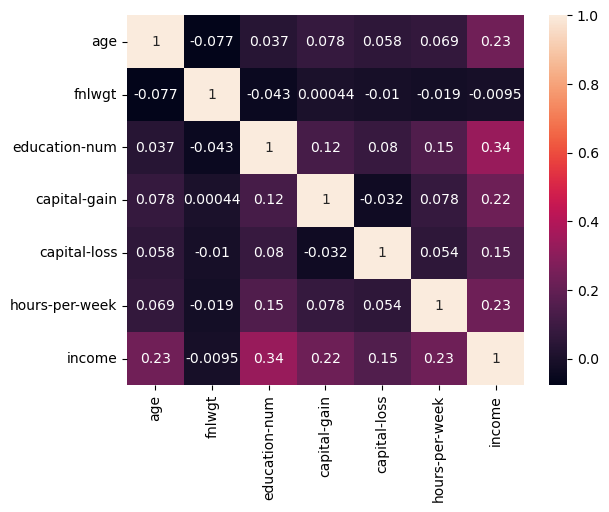

In [9]:
# visualize correlationship

# extract numerical features 
num_train = train.select_dtypes(exclude='object')

# encode income to numerical variable
num_train['income'] = train.income.replace([' <=50K', ' >50K'], [0,1])

# visualize feature correlations between pairs of variables
sns.heatmap(num_train.corr(), annot=True)

In [10]:
# Statistical summary for categorical variables
train.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32560,32560,32560,32560,32560,32560,32560,32560,32560
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


In [11]:
# null values
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

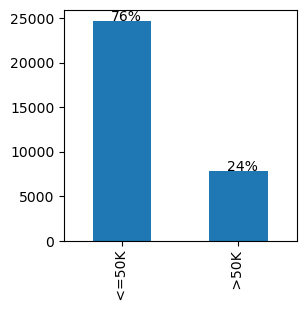

In [12]:
# plot distribution for target variable
ax = train.income.value_counts().plot.bar(figsize=(3,3))

for d in ax.patches:
    width=d.get_width()
    height=d.get_height()
    x,y=d.get_xy()
    ax.annotate(f'{height/len(train):.0%}', (x + width*0.3, y + height))


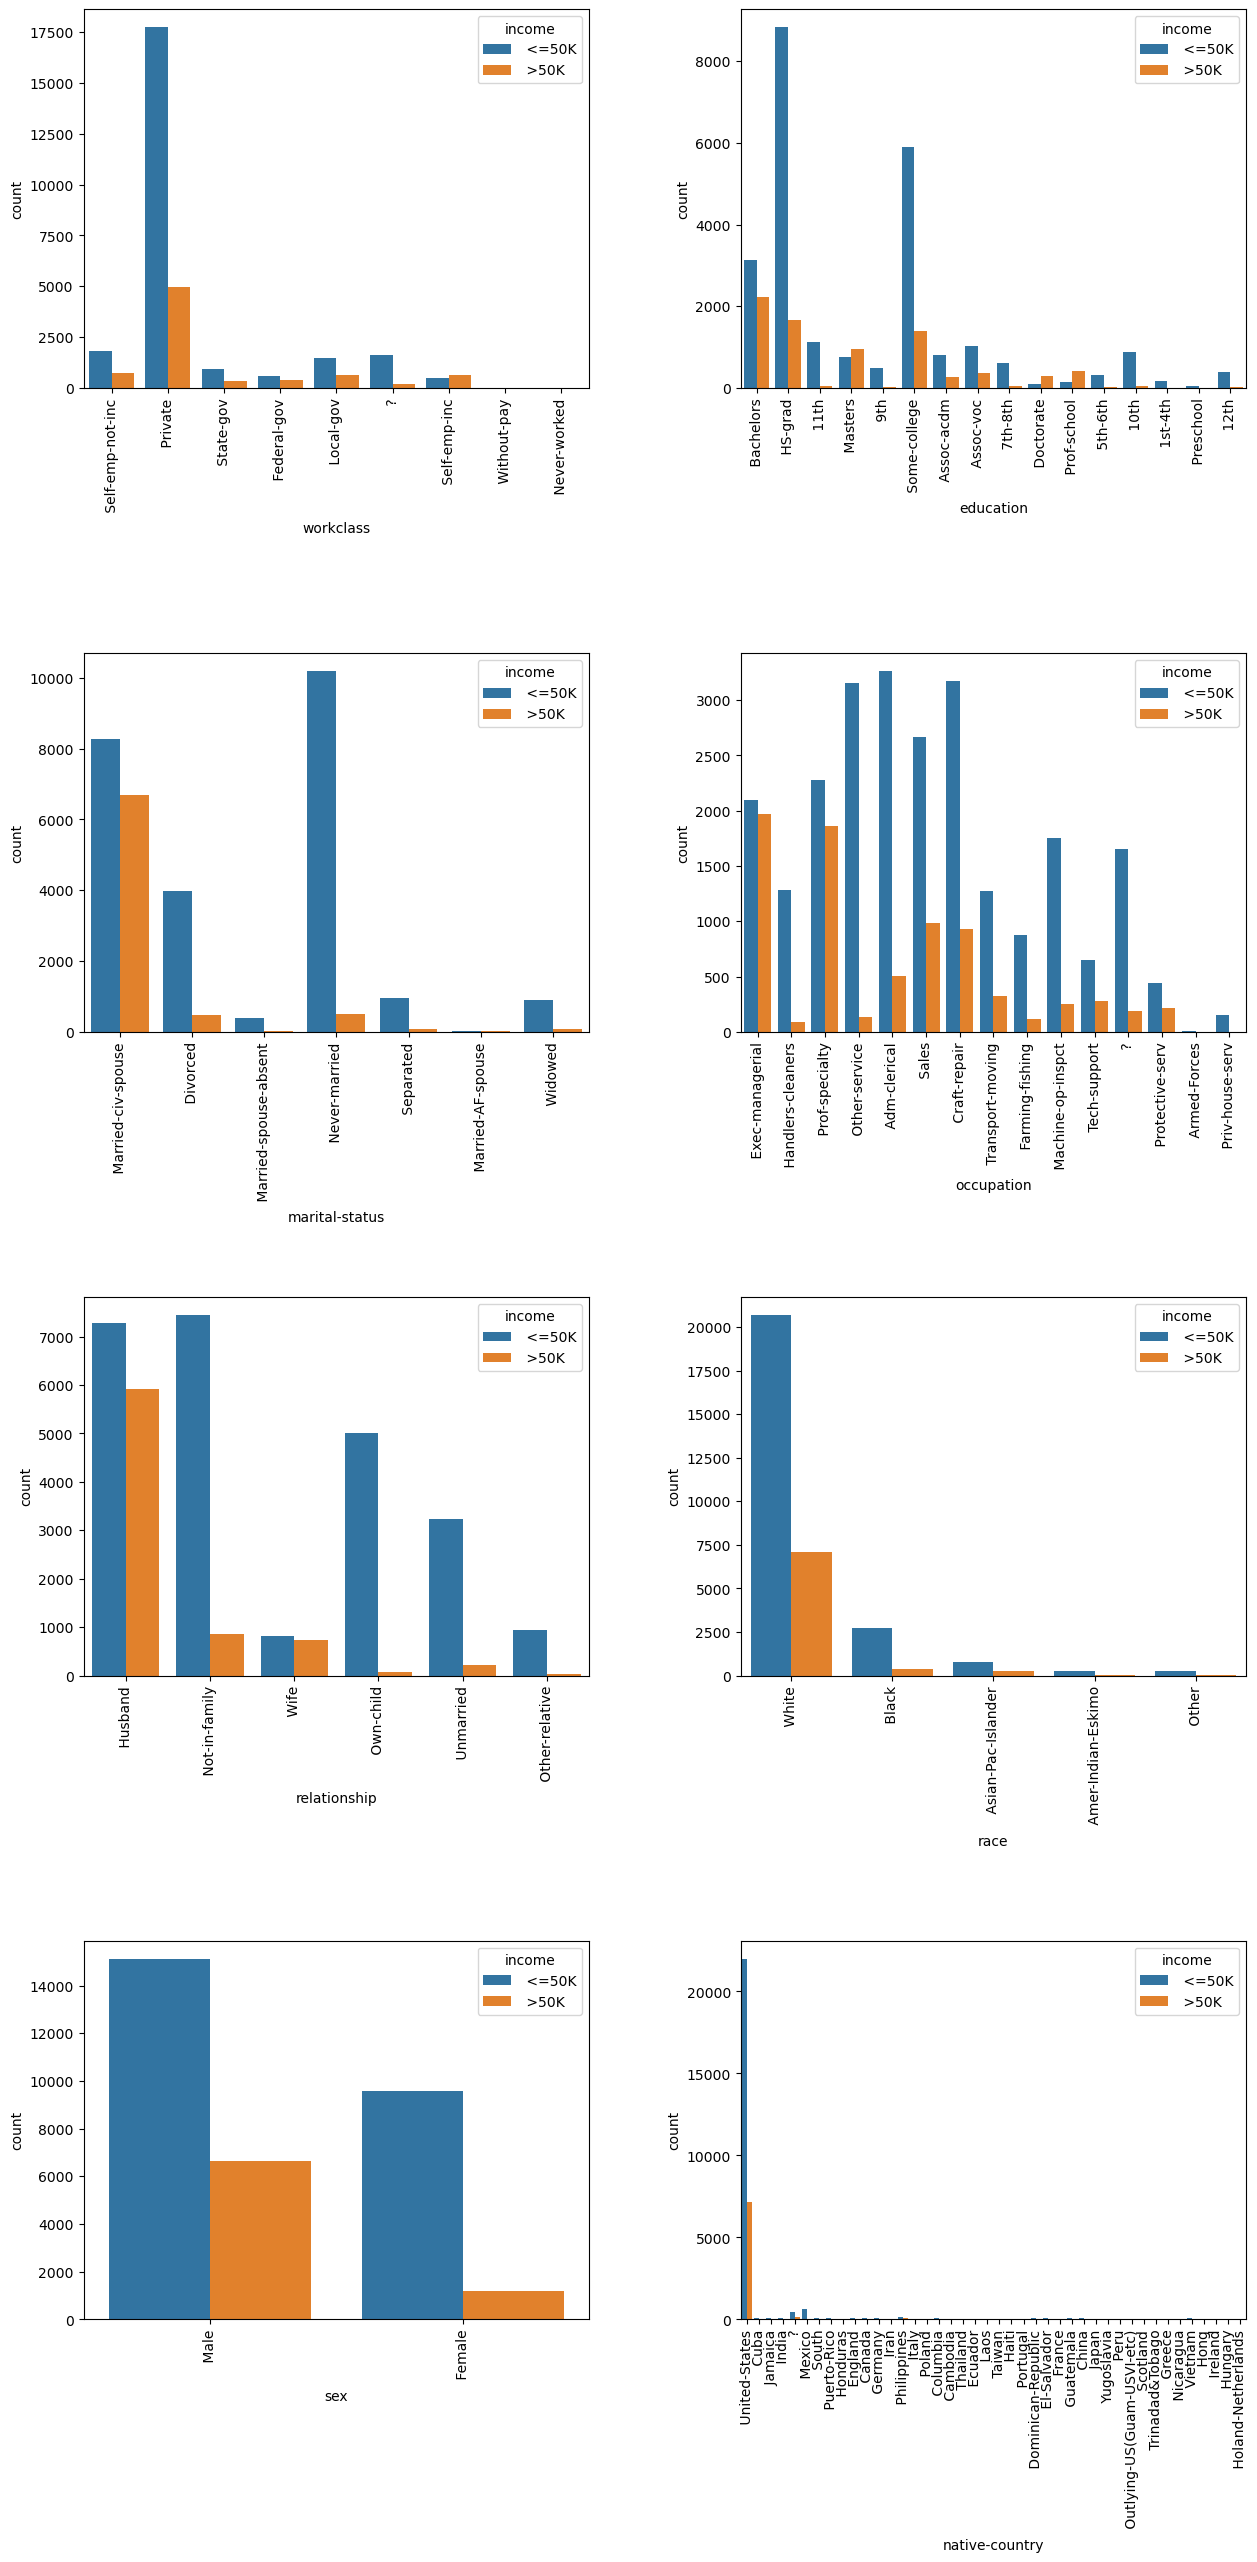

In [13]:
# visualize how categorical features distributed and associated with "income"
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,30))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
cat_train = train.select_dtypes(include='object')
cat_train.drop(labels='income', axis=1)
for f, ax in zip(cat_train.columns, axes.ravel()):
    sns.countplot(data=train, x=f, hue='income', ax=ax)
    ax.tick_params(axis='x', labelrotation = 90)
    
plt.show()

Most of the numerical features have a very weak correlation to each other ( corr  < 0.1) and a weak correlation to income level ( corr < 0.4). On the other side, the distribution for each categorical feature varies differently. Moreover, different categories have different income distributions for each feature. 


### 1.2.5 Exploring test data set

In [14]:
# a quick view on the data set
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [15]:
# understand variable types 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  native-country  16280 non-null  object
 14  income          16280 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [16]:
# statitical summary for numerical variables
test.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
age,16280.0,38.768305,13.849192,17.0,28.00,37.0,48.0,90.0
fnlwgt,16280.0,189433.382555,105717.748915,13492.0,116716.25,177829.5,238384.0,1490400.0
education-num,16280.0,10.073096,2.567511,1.0,9.00,10.0,12.0,16.0
capital-gain,16280.0,1081.971560,7584.164160,0.0,0.00,0.0,0.0,99999.0
capital-loss,16280.0,87.904668,403.117078,0.0,0.00,0.0,0.0,3770.0
hours-per-week,16280.0,40.392260,12.479715,1.0,40.00,40.0,45.0,99.0


In [17]:
test.income.unique()

array([' <=50K.', ' >50K.'], dtype=object)

<AxesSubplot:>

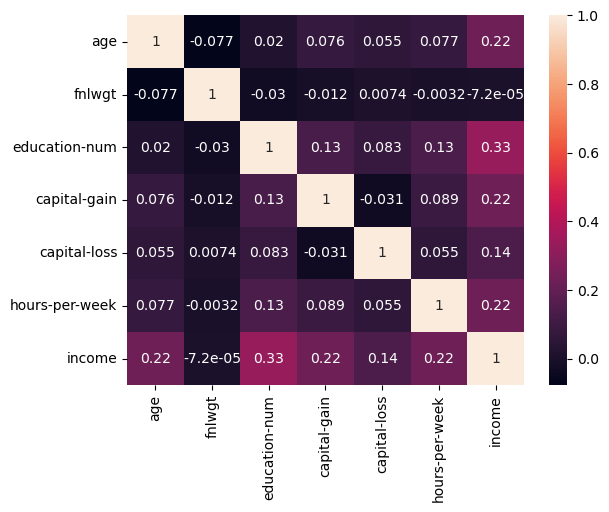

In [18]:
# visualize correlationship

# extract numerical features 
num_test = test.select_dtypes(exclude='object')

# encode income to numerical variable
num_test['income'] = test.income.replace([' <=50K.', ' >50K.'], [0,1])

# visualize feature correlations between pairs of variables
sns.heatmap(num_test.corr(), annot=True)

In [19]:
# Statistical summary for categorical variables
test.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,16280,16280,16280,16280,16280,16280,16280,16280,16280
unique,9,16,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K.
freq,11209,5283,7403,2032,6523,13946,10859,14661,12434


In [20]:
# null values
test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

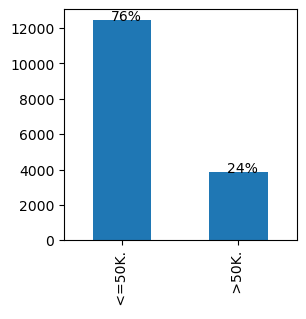

In [21]:
# plot distribution for target variable
ax = test.income.value_counts().plot.bar(figsize=(3,3))

for d in ax.patches:
    width=d.get_width()
    height=d.get_height()
    x,y=d.get_xy()
    ax.annotate(f'{height/len(test):.0%}', (x + width*0.3, y + height))


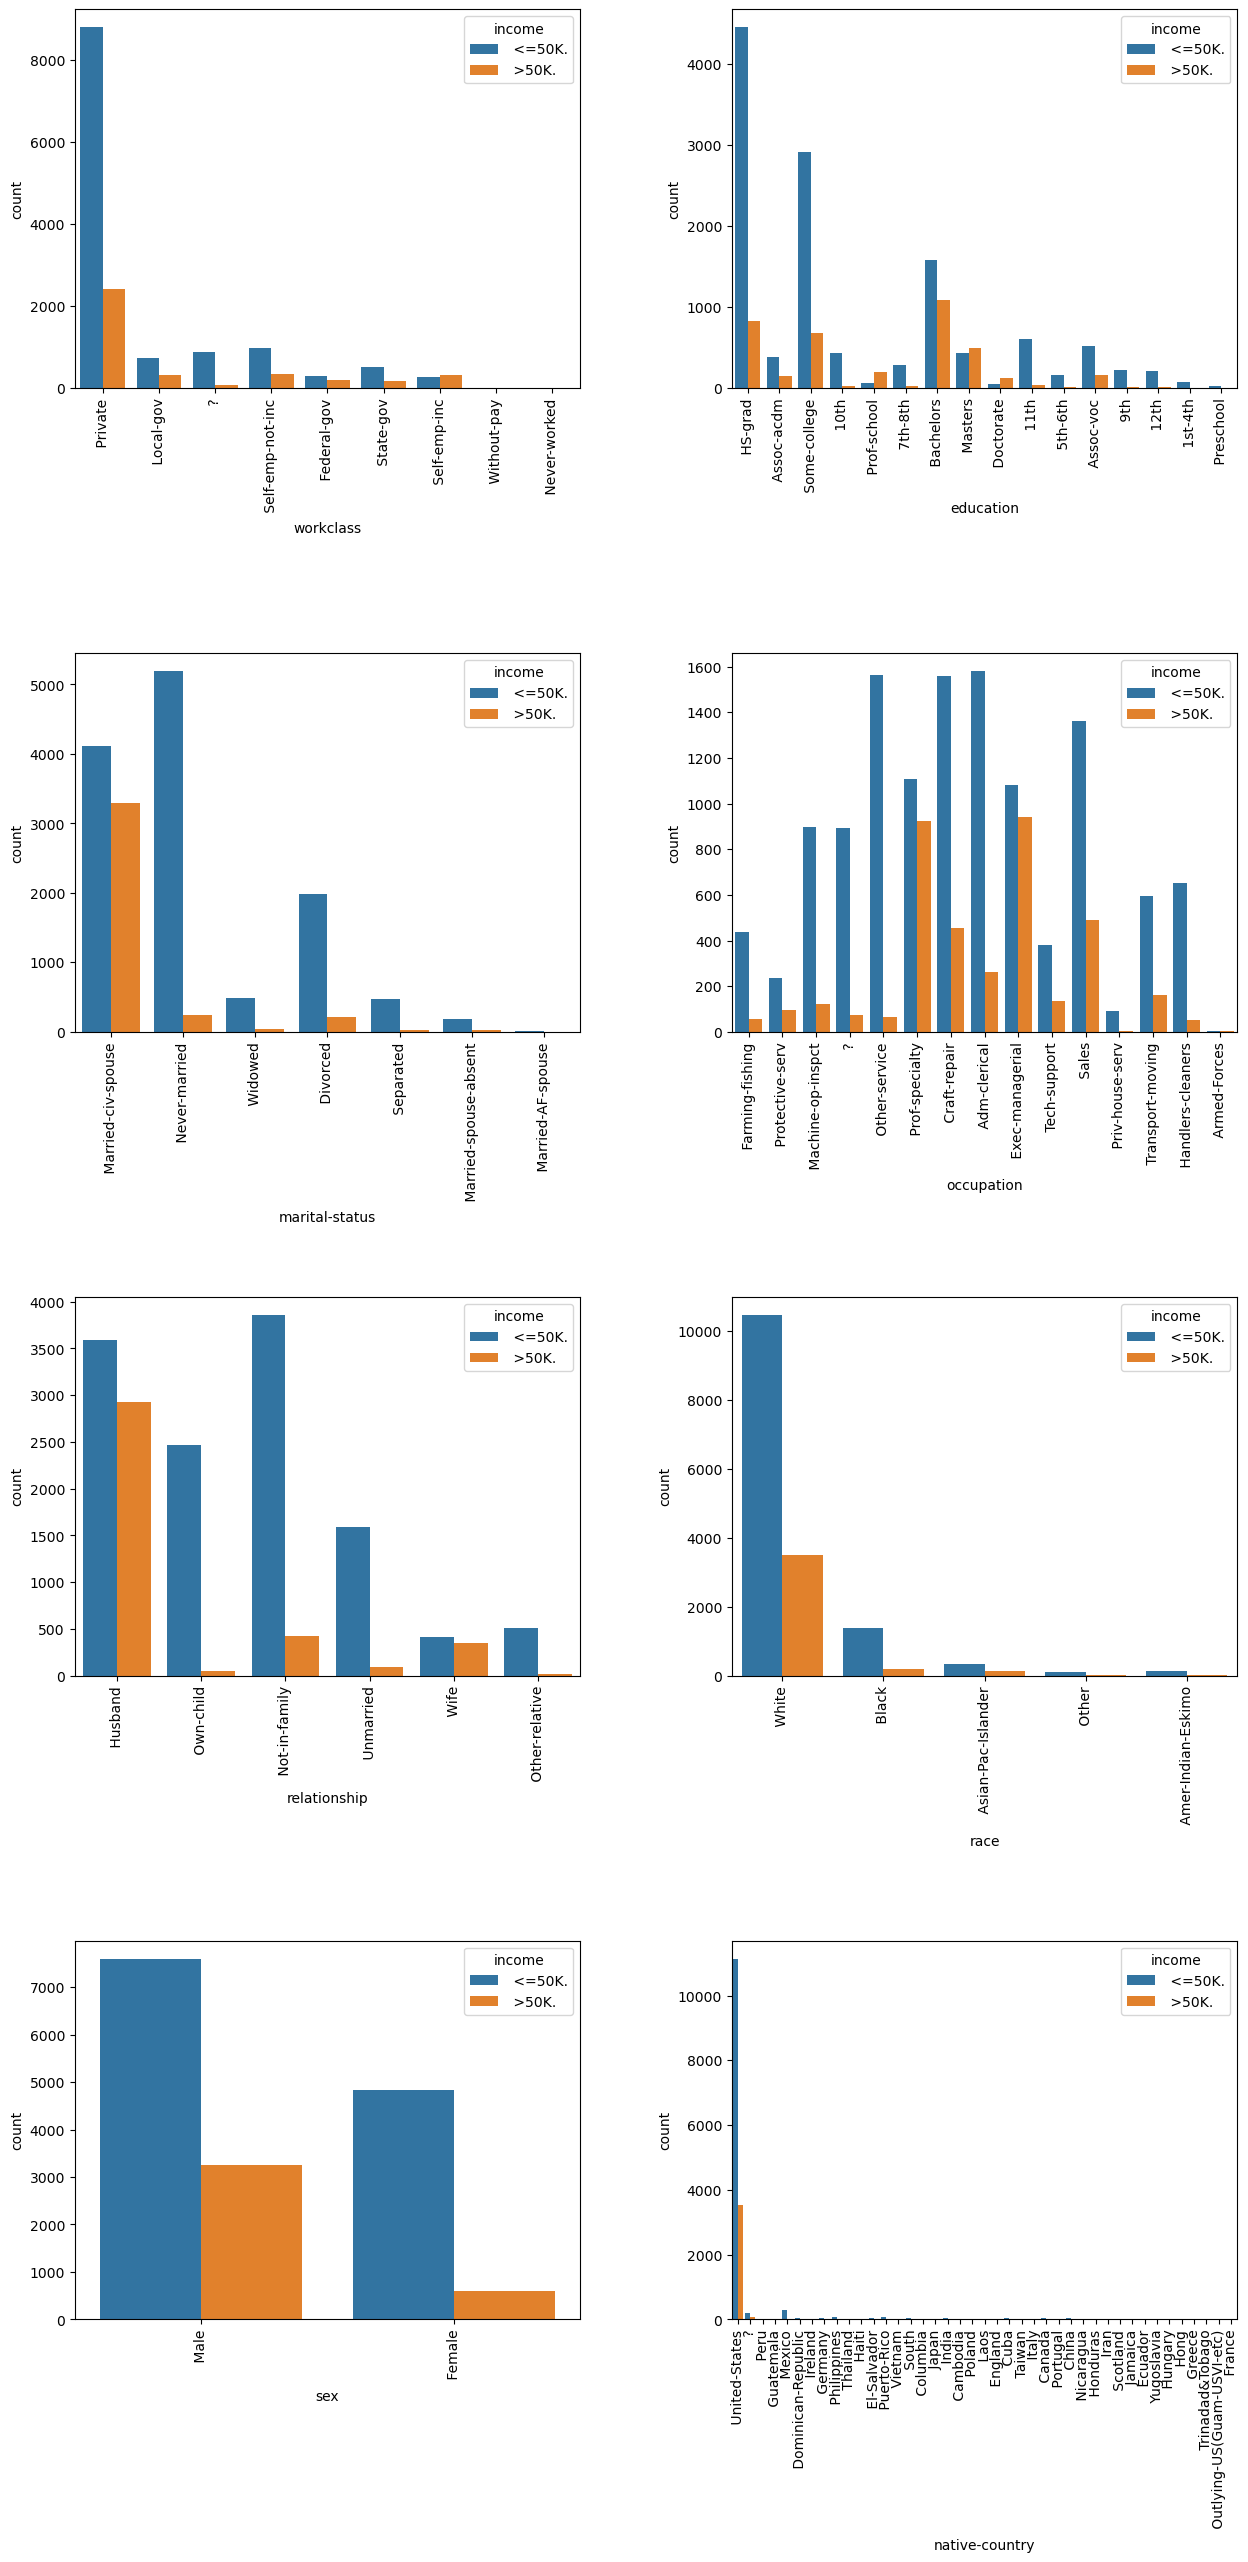

In [22]:
# visualize how categorical features distributed and associated with "income"
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,30))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
cat_test = test.select_dtypes(include='object')
cat_test.drop(labels='income', axis=1)
for f, ax in zip(cat_test.columns, axes.ravel()):
    sns.countplot(data=test, x=f, hue='income', ax=ax)
    ax.tick_params(axis='x', labelrotation = 90)
    
plt.show()

As shown above, the test data distribution is similar to the training data set. This affirms that the training dataset and testing dataset come from the same distribution as described in the Adult data description. Hence, we are able to use a model built on training data set to estimate the income level on the test dataset.

In [23]:
# remove noise symbols in 'income' variable
train['income'] = train['income'].str.replace(' ','', regex=True)
test['income'] = test['income'].str.replace('.','', regex=True).str.replace(' ','', regex=True)

In summary, this is a binary classification problem. The train data set contains over 32 thousand (32k) samples, with around 24% of people earning over 50k per year. The test data set contains over 16thousand(16k) samples with approximately the same income distribution as the train data set. Among 14 features, 6 of which are numerical with various mean values and standard deviations, and 8 of which are categorical features with multiple subcategories. Hence, we need to transform the data to homogeneous scale tensors for further modeling.

## 1.3 Methodology

### 1.3.1 The neuron network model 

The purpose of building an NN model for the Adult data set is to predict the target class on the unknown data. We started with a simple model that had limited statistical power. Next, we expand the model to gain more than enough capacity. Later, we tune the model to the optimal size with just the right power on the Adult data set. Last, we evaluate the optimum model on an unseen test data set. 

NN model can be thought of as a multi-stage information distillation process, where each layer is a filter that filters information sequentially. Each layer contains many neurons, and each neuron maps the input data to output by some transformation function. Such mapping can be expressed as weights and stored in the neuron's layer. The NN learning maps the input data (as weights of layers) to the final output (Chollet, 2017).

Our NN model should have statistical power to perform better than a random guess. Hence, we set a baseline model that ignores all the features and randomly guesses a person's income level following the income level distribution. Specifically, around 76% of the time, a person's income is no more than 50k, while 24% of the time, over 50k. 

We started with a simple NN model with only one hidden layer and plotted the performance on training and validation iterations. The simple NN model should have more predictive power than the baseline model. The next step is to expand (or shrink) the model capacity so that we have some ideas where the model underfits or overfits. Based on this understanding, we can build a reasonable hyperparameter space to explore an optimal model which can generalize on unseen test data. 

As Tensor flow requires the input data to be in the form of tensors and can work well with homogeneous data (large variance of input features could impact the computation convergence efficiency). Hence, we need normalize the numerical features and one-hot encode the categorical variables.


### 1.3.2 NN model hyperparameter tuning 

An optimum model can capture the desired patterns in the data, which is simple enough to generalize and complex enough to capture enough patterns in our data. We will adopt two regularization approaches in searching for the optimum model.

The first approach is early stopping, which signals a model to stop when the learning slows down. When learning data patterns slow down, the model learns noise patterns in the following training. Such learning will decrease model performance in the validation data as the noise patterns are not generalizable in the unseen data. Early stopping lets the model learn the right amount of patterns, enabling better generalization.

The second approach is dropout layers. Dropout layers avoid the co-adaption of neurons by randomly "deleting" some neurons in the training process. In each update of weights and biases, a model randomly drops out some portion of neurons in the dropout layer. Hence, the balanced neurons could lean more independently and plays a better role in final output generation. Dropout allows more neurons to learn inference power better.

Hyperparameter tuning evaluates different combinations of hyperparameters in the defined hyperparameter space to find the optimum model that gives the best performance based on the validation data set. Usually, the hyperparameter space is defined based on a person's knowledge and experience. There are different approaches to sampling from hyperparameter space and searching for optimal hyperparameters. In this coursework, we use a Bayesian optimizer.

In grid search hyperparameter tuning, it greedily samples every possible combination of hyperparameter set and searches for the best solution that provides minimum loss in the training process. This process is computationally expensive. Moreover, the optimal hyperparameters may not be found if we have not defined them in the search space. In comparison, bayesian optimization provides a more efficient way of sampling hyperparameter space, which could be a continuous range defined by the user. In bayesian optimization, a network is instantiated by evaluating the performance of some models with random hyperparameter combinations sampled from hyperparameter space. Followed by that, the Bayesian optimizer estimates the optimum hyperparameters combination based on existing information. The true loss will then be evaluated based on the estimated optimum hyperparameters. After that, the new sample will be added to the Bayesian network and repeat the process of estimating optimal hyperparameters based on previous attempts. As a result, the Bayesian optimizer could sample more efficiently in hyperparameter space.

### 1.3.3 The measure of success

#### 1.3.3.1 The loss function

In logistic regression, a loss function L(y_predict, y_label) as followingly is widely used to measure algorithms performance. L(y_predict, y_label) = - y_label * log y_predict - (1 - y_label) * log (1 - y_predict). In a NN model, inputs are fed forward to deeper layers of neurons to calculate the final output with different parameters. Model performance could be measured by the closeness of predicted outputs to actual labels. The loss function L(y_predict, y_label) could be used to measure such closeness. With a backpropagation approach, we can train a NN model(specifically, weights and biases) by minimizing the loss function. Instead of training one random sample at a time, training a mini bath of data at one time could give us better results by capturing patterns from more data. At the same time, computationally efficient, especially when the data size is big.

#### 1.3.3.2 Accuracy and Area Under the Curve(AUC)

However, the loss is not an intuitive measure representing our NN model's performance. We usually crosstab the actual labels against predicted labels as a confusion matrix for binary classifications. Accuracy is the correct predicted label against all predictions, widely used to measure success. However, in our problem, if we predict all classes to the majority class(alias, negative class, class of income "<=50k"), our accuracy is around 76%. Hence, accuracy is not a good metric for evaluatingur model's statistical power. Precision measures how many positive predictions are positive samples, while recall measures how many positive samples are correctly predicted as positive. Precision or recall alone may not be able to reflect how well our predictions are. For example, a model's predicted positive labels could be a 100% positive sample(alias, precision equals 100%). However, only a few positive samples are identified(alias, very low recall). Alternatively, a model could spot all positive samples(alias, recall equals 100%) while spotting many negative classes as positive(alias, low precision). Hence, we decide to use the area under the curve(AUC metric) to measure model performance. In Keras, the metrics function provides an AUC that plots precision versus recall values.

### 1.3.4 Deciding on an evaluation protocol

Machine learning has a few widely used evaluation protocols, such as cross-validation (CV), iterative CV, and hold-out method. Cross-validation split data into k folds and training models on the (1- 1/k) folds while validation on balance (1/k) fold iteratively. Iterative k-fold CV simply iterates the whole CV process several times(e.g., n times) and takes the average of the n results. The hold-out validation method will split the training dataset further into training_subset and validation(hold-out) data sets. The model would be trained on the training-subset and validated on the validation data set. CV allows the model to be trained and evaluated on the whole data. However, a CV is computationally expensive.

On the contrary, the hold-out method computed the result from only one data split. Hence, the computation is much cheaper, but how the data split could probably impact the evaluation result. Generally, hold-out is suitable to use when the data size is big, while CV (or iterative CV) is preferable when the data size is small.

According to the above statistics, we have over 32k samples in the training data and over 16k in the testing data. Therefore, adopting a hold-out method for model validation would be feasible.

## 1.4 Implementation and results

### 1.4.1 Preparing the data

#### 1.4.1.1 Data normalization

As the above data statistics show, the Adult data set includes six heterogeneous numerical features. The large variance of input features could impact the computation convergence efficiency. Next, we have eight categorical features. Tensor flow requires the input data to be in the form of tensors. Hence, we will normalize the numerical features and one-hot encode the categorical features. The output label will also need to be converted to numerical form.

In [24]:
# normalizing numerical features

# instantiate a standard scaler model
scaler = StandardScaler()

# Train the scaler model with train data set
scaler.fit(train.select_dtypes(exclude='object'))

# transform numerical features in train data set
train_num = scaler.transform(train.select_dtypes(exclude='object'))

# transform numerical features in test data set
test_num = scaler.transform(test.select_dtypes(exclude='object'))

# print out transferred data shape
print("train_num: ", train_num.shape, '\n' "test_num: ", test_num.shape)

train_num:  (32560, 6) 
test_num:  (16280, 6)


In [25]:
# one hot encode categorical features 

# instantiate an encoder
encoder = OneHotEncoder(sparse=False)

# Train encoder with train data set
encoder.fit(train.select_dtypes(include='object').iloc[:,:-1])

# transform categorical features in train data set
train_cat = encoder.transform(train.select_dtypes(include='object').iloc[:,:-1])

# transform categorical features in test data set
test_cat = encoder.transform(test.select_dtypes(include='object').iloc[:,:-1])

#print out transferred data shape
print("train_cat: ", train_cat.shape, "\n", "test_cat: ", test_cat.shape)

train_cat:  (32560, 102) 
 test_cat:  (16280, 102)


In [26]:
train.iloc[:,-1][10]

'>50K'

In [27]:
# encode label column

# instantiate a label encoder
label= LabelEncoder()

# train label encoder with train data set
label.fit(train.iloc[:,-1])

# encode labels in train data set
y_train=label.transform(train.iloc[:,-1])

# encode labels in test data set
y_test=label.transform(test.iloc[:,-1])

# print out data shape
print("y_train: ", y_train.shape, "\ny_test: ", y_test.shape)
 
print('<=50K: ', "class", label.transform(['<=50K']))
print('>50K: ', "class", label.transform(['>50K']))

y_train:  (32560,) 
y_test:  (16280,)
<=50K:  class [0]
>50K:  class [1]


In [28]:
# form tensors from all features

X_train = np.concatenate((train_num, train_cat), axis=1)
X_test = np.concatenate((test_num, test_cat), axis=1)

# print out input data shape
print("X_train: ", X_train.shape, "\nX_test: ", X_test.shape)

X_train:  (32560, 108) 
X_test:  (16280, 108)


#### 1.4.1.2 Train-validation data sets split

During hold-out sampling, it is essential that the splitted samples could sufficiently represent the original data, especially for imbalanced data. Stratified sampling technics could help us to acheive this.

In [29]:
# split out hold-out validation data set from train data 
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.3,
                                                          stratify=y_train, 
                                                          random_state=200)

# print out data shape
print("X_train_sub: ", X_train_sub.shape, "\nX_val: ", X_val.shape, "\ny_train_sub: ", 
      y_train_sub.shape, "\ny_val: ", y_val.shape)

X_train_sub:  (22792, 108) 
X_val:  (9768, 108) 
y_train_sub:  (22792,) 
y_val:  (9768,)


### 1.4.2 The Baseline model

In [30]:
# instantiate baseline model that predicts like random guess
baseline = DummyClassifier(strategy='prior')

# train baseline model
baseline.fit(X_train_sub, y_train_sub)

# predict labels of test data
predict = baseline.predict(X_val)

# get precision, recall
precision, recall, _ = precision_recall_curve(y_val, predict)

# get area under the curve based on precision and recall
score = auc(precision, recall)

print("Baseline model AUC(PR curve): ", score)
print("Baseline model Accuracy: ", baseline.score(X_val, y_val))


Baseline model AUC(PR curve):  0.3796068796068796
Baseline model Accuracy:  0.7592137592137592


Our NN model should have statistical power to perform better than a random guess. Hence, we set a baseline model that ignores all the features and randomly guess a person's income level following the income level distribution. To be specific, around 76% of time, we guess a person's income less than 50k while 24% of time, over 50k. 

### 1.4.3 Developing a simple model that does better than baseline

#### 1.4.3.1 Build a simple NN model with one hidden layer

The purpose of building an NN model for the Adult data set is to predict the target class on the unknown data. Therefore, a NN model should be able to learn the desired patterns in the data and make inferences on unseen data based on the learned patterns. However, the NN model could also learn too many patterns when the number of hidden layers increases or over too many training epochs. We will start with a few hidden layers to build a 'simple' NN model with some statistical inference power. Hence, the model could learn only a few patterns in training data and make predictions better than a random guess. Later, we will increase the number of hidden layers and training epochs to let the model learn too many patterns. Among these, those noise patterns may not be able to generalize on unseen data and deteriorate the model validation performance.

In [31]:
# build a simple NN model that may underfit the data
model1 = models.Sequential()
model1.add(layers.Dense(10, activation = 'relu', input_shape = (108,)))
model1.add(layers.Dense(1, activation = "sigmoid"))

model1.compile(optimizer = RMSprop(learning_rate =0.01),
             loss = 'binary_crossentropy',
             metrics = ["accuracy",metrics.AUC(curve='PR')])

In [32]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1090      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [33]:
MAX_EPOCHS = 150
BATCH_SIZE = 600

history1 = model1.fit(
    X_train_sub, y_train_sub,
    epochs = MAX_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val),
    verbose = 2
    )

Epoch 1/150
38/38 - 1s - loss: 0.4251 - accuracy: 0.7971 - auc: 0.6266 - val_loss: 0.3291 - val_accuracy: 0.8514 - val_auc: 0.7558 - 583ms/epoch - 15ms/step
Epoch 2/150
38/38 - 0s - loss: 0.3251 - accuracy: 0.8501 - auc: 0.7602 - val_loss: 0.3197 - val_accuracy: 0.8537 - val_auc: 0.7683 - 56ms/epoch - 1ms/step
Epoch 3/150
38/38 - 0s - loss: 0.3208 - accuracy: 0.8509 - auc: 0.7659 - val_loss: 0.3159 - val_accuracy: 0.8549 - val_auc: 0.7716 - 76ms/epoch - 2ms/step
Epoch 4/150
38/38 - 0s - loss: 0.3176 - accuracy: 0.8514 - auc: 0.7688 - val_loss: 0.3157 - val_accuracy: 0.8530 - val_auc: 0.7728 - 48ms/epoch - 1ms/step
Epoch 5/150
38/38 - 0s - loss: 0.3154 - accuracy: 0.8530 - auc: 0.7722 - val_loss: 0.3180 - val_accuracy: 0.8508 - val_auc: 0.7748 - 45ms/epoch - 1ms/step
Epoch 6/150
38/38 - 0s - loss: 0.3129 - accuracy: 0.8542 - auc: 0.7763 - val_loss: 0.3120 - val_accuracy: 0.8551 - val_auc: 0.7772 - 44ms/epoch - 1ms/step
Epoch 7/150
38/38 - 0s - loss: 0.3099 - accuracy: 0.8569 - auc: 0.78

Epoch 54/150
38/38 - 0s - loss: 0.2907 - accuracy: 0.8653 - auc: 0.8040 - val_loss: 0.3150 - val_accuracy: 0.8533 - val_auc: 0.7743 - 45ms/epoch - 1ms/step
Epoch 55/150
38/38 - 0s - loss: 0.2902 - accuracy: 0.8670 - auc: 0.8055 - val_loss: 0.3164 - val_accuracy: 0.8540 - val_auc: 0.7721 - 46ms/epoch - 1ms/step
Epoch 56/150
38/38 - 0s - loss: 0.2903 - accuracy: 0.8656 - auc: 0.8050 - val_loss: 0.3205 - val_accuracy: 0.8505 - val_auc: 0.7736 - 46ms/epoch - 1ms/step
Epoch 57/150
38/38 - 0s - loss: 0.2903 - accuracy: 0.8657 - auc: 0.8051 - val_loss: 0.3172 - val_accuracy: 0.8542 - val_auc: 0.7709 - 46ms/epoch - 1ms/step
Epoch 58/150
38/38 - 0s - loss: 0.2895 - accuracy: 0.8677 - auc: 0.8063 - val_loss: 0.3165 - val_accuracy: 0.8533 - val_auc: 0.7724 - 45ms/epoch - 1ms/step
Epoch 59/150
38/38 - 0s - loss: 0.2895 - accuracy: 0.8675 - auc: 0.8061 - val_loss: 0.3167 - val_accuracy: 0.8552 - val_auc: 0.7708 - 45ms/epoch - 1ms/step
Epoch 60/150
38/38 - 0s - loss: 0.2897 - accuracy: 0.8674 - auc:

Epoch 107/150
38/38 - 0s - loss: 0.2861 - accuracy: 0.8697 - auc: 0.8114 - val_loss: 0.3224 - val_accuracy: 0.8534 - val_auc: 0.7655 - 45ms/epoch - 1ms/step
Epoch 108/150
38/38 - 0s - loss: 0.2856 - accuracy: 0.8689 - auc: 0.8115 - val_loss: 0.3216 - val_accuracy: 0.8520 - val_auc: 0.7674 - 44ms/epoch - 1ms/step
Epoch 109/150
38/38 - 0s - loss: 0.2861 - accuracy: 0.8675 - auc: 0.8114 - val_loss: 0.3231 - val_accuracy: 0.8515 - val_auc: 0.7661 - 44ms/epoch - 1ms/step
Epoch 110/150
38/38 - 0s - loss: 0.2856 - accuracy: 0.8695 - auc: 0.8116 - val_loss: 0.3224 - val_accuracy: 0.8527 - val_auc: 0.7656 - 44ms/epoch - 1ms/step
Epoch 111/150
38/38 - 0s - loss: 0.2862 - accuracy: 0.8682 - auc: 0.8103 - val_loss: 0.3219 - val_accuracy: 0.8522 - val_auc: 0.7675 - 45ms/epoch - 1ms/step
Epoch 112/150
38/38 - 0s - loss: 0.2855 - accuracy: 0.8689 - auc: 0.8120 - val_loss: 0.3213 - val_accuracy: 0.8515 - val_auc: 0.7683 - 44ms/epoch - 1ms/step
Epoch 113/150
38/38 - 0s - loss: 0.2857 - accuracy: 0.8696

The optimum epochs number is:  11 epochs
The minimum validation loss value is:  0.3094039559364319


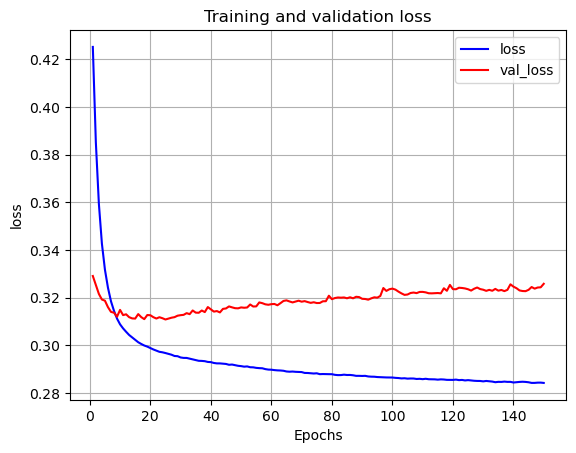

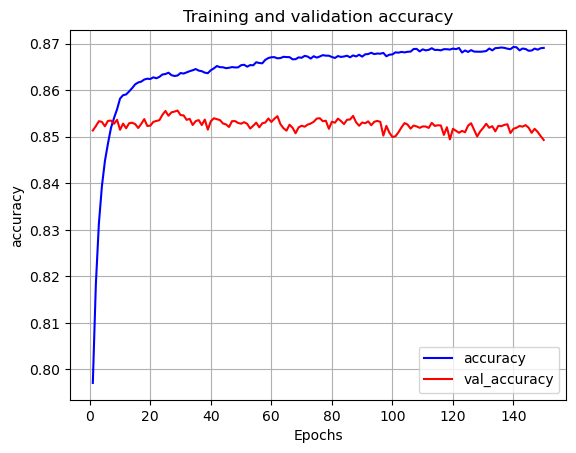

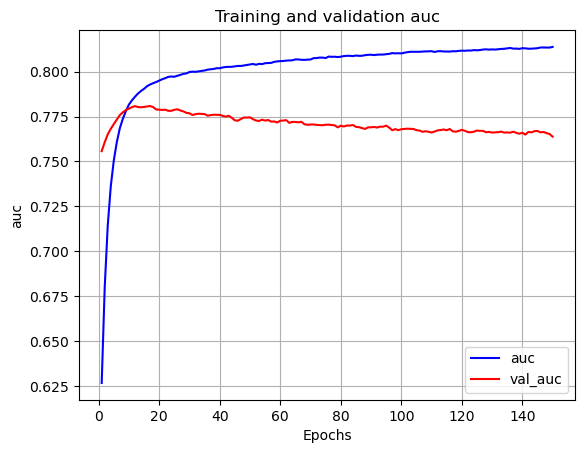

In [34]:
print("The optimum epochs number is: ", np.argmin(history1.history['val_loss'])+1, "epochs")
print("The minimum validation loss value is: ", min(history1.history['val_loss']))

# visualize the performance for each training and validation epochs
for i in range(3):
    performance_curve(history1, i)

The plots showed that our model has higher AUC and accuracy than the baseline model. Moreover, the accuracy and AUC values keep on increasing with continuous training until some epochs. Despite the fact that we only have one hidden layer, the model overfits data. In the next part, we will develop a model without any hidden layer(similar to logistic regression) which may underfit data.

#### 1.4.3.2 Simple model without any hidden layers

In [35]:
# Logistic Regression

model0 = models.Sequential()
model0.add(layers.Dense(1, activation = "sigmoid", input_shape = (108,)))

model0.compile(optimizer = RMSprop(learning_rate =0.01),
             loss = 'binary_crossentropy',
             metrics=["accuracy", metrics.AUC(curve='PR')])

In [36]:
# train the simple NN model with more epochs
history0 = model0.fit(
    X_train_sub, y_train_sub,
    epochs = MAX_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val),
    verbose = 2
    )

Epoch 1/150
38/38 - 0s - loss: 0.4462 - accuracy: 0.7887 - auc_1: 0.5701 - val_loss: 0.3657 - val_accuracy: 0.8327 - val_auc_1: 0.7055 - 414ms/epoch - 11ms/step
Epoch 2/150
38/38 - 0s - loss: 0.3493 - accuracy: 0.8372 - auc_1: 0.7252 - val_loss: 0.3394 - val_accuracy: 0.8443 - val_auc_1: 0.7309 - 43ms/epoch - 1ms/step
Epoch 3/150
38/38 - 0s - loss: 0.3331 - accuracy: 0.8435 - auc_1: 0.7444 - val_loss: 0.3286 - val_accuracy: 0.8501 - val_auc_1: 0.7461 - 40ms/epoch - 1ms/step
Epoch 4/150
38/38 - 0s - loss: 0.3258 - accuracy: 0.8481 - auc_1: 0.7554 - val_loss: 0.3242 - val_accuracy: 0.8521 - val_auc_1: 0.7554 - 40ms/epoch - 1ms/step
Epoch 5/150
38/38 - 0s - loss: 0.3222 - accuracy: 0.8499 - auc_1: 0.7616 - val_loss: 0.3214 - val_accuracy: 0.8511 - val_auc_1: 0.7604 - 39ms/epoch - 1ms/step
Epoch 6/150
38/38 - 0s - loss: 0.3202 - accuracy: 0.8510 - auc_1: 0.7645 - val_loss: 0.3193 - val_accuracy: 0.8528 - val_auc_1: 0.7645 - 40ms/epoch - 1ms/step
Epoch 7/150
38/38 - 0s - loss: 0.3192 - accu

Epoch 53/150
38/38 - 0s - loss: 0.3172 - accuracy: 0.8524 - auc_1: 0.7698 - val_loss: 0.3196 - val_accuracy: 0.8521 - val_auc_1: 0.7672 - 42ms/epoch - 1ms/step
Epoch 54/150
38/38 - 0s - loss: 0.3174 - accuracy: 0.8517 - auc_1: 0.7693 - val_loss: 0.3201 - val_accuracy: 0.8526 - val_auc_1: 0.7674 - 40ms/epoch - 1ms/step
Epoch 55/150
38/38 - 0s - loss: 0.3172 - accuracy: 0.8522 - auc_1: 0.7701 - val_loss: 0.3185 - val_accuracy: 0.8531 - val_auc_1: 0.7664 - 41ms/epoch - 1ms/step
Epoch 56/150
38/38 - 0s - loss: 0.3170 - accuracy: 0.8524 - auc_1: 0.7700 - val_loss: 0.3192 - val_accuracy: 0.8532 - val_auc_1: 0.7678 - 51ms/epoch - 1ms/step
Epoch 57/150
38/38 - 0s - loss: 0.3173 - accuracy: 0.8521 - auc_1: 0.7697 - val_loss: 0.3182 - val_accuracy: 0.8534 - val_auc_1: 0.7674 - 41ms/epoch - 1ms/step
Epoch 58/150
38/38 - 0s - loss: 0.3171 - accuracy: 0.8516 - auc_1: 0.7696 - val_loss: 0.3187 - val_accuracy: 0.8526 - val_auc_1: 0.7666 - 39ms/epoch - 1ms/step
Epoch 59/150
38/38 - 0s - loss: 0.3172 -

Epoch 105/150
38/38 - 0s - loss: 0.3169 - accuracy: 0.8528 - auc_1: 0.7699 - val_loss: 0.3187 - val_accuracy: 0.8534 - val_auc_1: 0.7673 - 40ms/epoch - 1ms/step
Epoch 106/150
38/38 - 0s - loss: 0.3170 - accuracy: 0.8516 - auc_1: 0.7698 - val_loss: 0.3187 - val_accuracy: 0.8535 - val_auc_1: 0.7669 - 40ms/epoch - 1ms/step
Epoch 107/150
38/38 - 0s - loss: 0.3172 - accuracy: 0.8520 - auc_1: 0.7694 - val_loss: 0.3190 - val_accuracy: 0.8537 - val_auc_1: 0.7671 - 51ms/epoch - 1ms/step
Epoch 108/150
38/38 - 0s - loss: 0.3170 - accuracy: 0.8521 - auc_1: 0.7701 - val_loss: 0.3200 - val_accuracy: 0.8525 - val_auc_1: 0.7662 - 40ms/epoch - 1ms/step
Epoch 109/150
38/38 - 0s - loss: 0.3172 - accuracy: 0.8520 - auc_1: 0.7697 - val_loss: 0.3188 - val_accuracy: 0.8535 - val_auc_1: 0.7664 - 42ms/epoch - 1ms/step
Epoch 110/150
38/38 - 0s - loss: 0.3170 - accuracy: 0.8523 - auc_1: 0.7697 - val_loss: 0.3189 - val_accuracy: 0.8533 - val_auc_1: 0.7665 - 41ms/epoch - 1ms/step
Epoch 111/150
38/38 - 0s - loss: 0

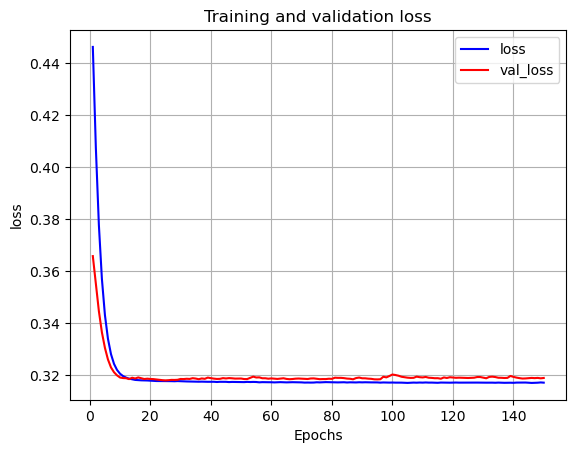

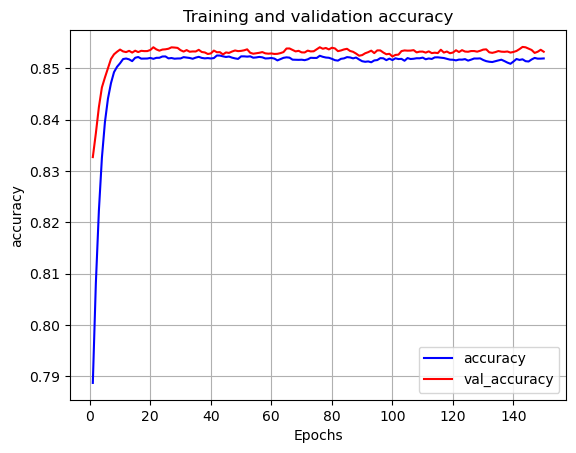

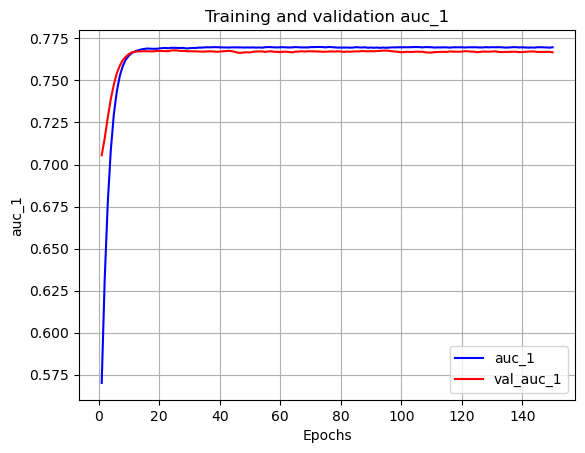

In [37]:
# visualize the performance for each training and validation epochs
for i in range(3):
    performance_curve(history0, i)

We found that a NN model without hidden layers could quickly learn these dataset patterns. However, the model reached its maximum capacity by less than 20 epochs. The training and validation performance curves flattened after some epochs, suggesting model underfits data.

Later, we want to build a deeper NN model with more hidden layers and evaluate the model's capability to learn. The deeper NN model should be able to learn more patterns with fewer iterations. As we randomly assign the NN models architecture, we need to explore the optimal architecture that could help us capture just enough patterns in data. We will define the hyperparameter space based on the understanding from models explored. Following the "deep" NN model exploration, we will use hyperparameter tuning to find the optimal NN model which gives us most predictive power.

### 1.4.4 Buid a "deep" NN model that overfits the data

In [38]:
# build a simple NN model that may underfit the data
model4 = models.Sequential()
model4.add(layers.Dense(39, activation = 'relu', input_shape = (108,)))
model4.add(layers.Dense(39, activation = 'relu'))
model4.add(layers.Dense(39, activation = 'relu'))
model4.add(layers.Dense(39, activation = 'relu'))
model4.add(layers.Dense(1, activation = "sigmoid"))

model4.compile(optimizer = RMSprop(learning_rate =0.01),
             loss = 'binary_crossentropy',
             metrics = ["accuracy", metrics.AUC(curve='PR')])

In [39]:
history4=model4.fit(
    X_train_sub, y_train_sub,
    epochs = MAX_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val),
    verbose = 2
    )

Epoch 1/150
38/38 - 1s - loss: 0.3662 - accuracy: 0.8199 - auc_2: 0.6947 - val_loss: 0.3138 - val_accuracy: 0.8525 - val_auc_2: 0.7779 - 629ms/epoch - 17ms/step
Epoch 2/150
38/38 - 0s - loss: 0.3166 - accuracy: 0.8537 - auc_2: 0.7713 - val_loss: 0.3441 - val_accuracy: 0.8288 - val_auc_2: 0.7826 - 88ms/epoch - 2ms/step
Epoch 3/150
38/38 - 0s - loss: 0.3142 - accuracy: 0.8547 - auc_2: 0.7764 - val_loss: 0.3053 - val_accuracy: 0.8585 - val_auc_2: 0.7850 - 86ms/epoch - 2ms/step
Epoch 4/150
38/38 - 0s - loss: 0.3065 - accuracy: 0.8585 - auc_2: 0.7860 - val_loss: 0.3081 - val_accuracy: 0.8572 - val_auc_2: 0.7858 - 83ms/epoch - 2ms/step
Epoch 5/150
38/38 - 0s - loss: 0.3026 - accuracy: 0.8620 - auc_2: 0.7911 - val_loss: 0.3174 - val_accuracy: 0.8520 - val_auc_2: 0.7849 - 82ms/epoch - 2ms/step
Epoch 6/150
38/38 - 0s - loss: 0.3009 - accuracy: 0.8632 - auc_2: 0.7962 - val_loss: 0.3074 - val_accuracy: 0.8585 - val_auc_2: 0.7851 - 90ms/epoch - 2ms/step
Epoch 7/150
38/38 - 0s - loss: 0.2962 - accu

Epoch 53/150
38/38 - 0s - loss: 0.2061 - accuracy: 0.9024 - auc_2: 0.8963 - val_loss: 0.5167 - val_accuracy: 0.8339 - val_auc_2: 0.7017 - 92ms/epoch - 2ms/step
Epoch 54/150
38/38 - 0s - loss: 0.2080 - accuracy: 0.9011 - auc_2: 0.8945 - val_loss: 0.5029 - val_accuracy: 0.8376 - val_auc_2: 0.7187 - 79ms/epoch - 2ms/step
Epoch 55/150
38/38 - 0s - loss: 0.2039 - accuracy: 0.9026 - auc_2: 0.8968 - val_loss: 0.5028 - val_accuracy: 0.8377 - val_auc_2: 0.7028 - 77ms/epoch - 2ms/step
Epoch 56/150
38/38 - 0s - loss: 0.2009 - accuracy: 0.9044 - auc_2: 0.9004 - val_loss: 0.5546 - val_accuracy: 0.8251 - val_auc_2: 0.6890 - 86ms/epoch - 2ms/step
Epoch 57/150
38/38 - 0s - loss: 0.2041 - accuracy: 0.9046 - auc_2: 0.8984 - val_loss: 0.5089 - val_accuracy: 0.8398 - val_auc_2: 0.7141 - 81ms/epoch - 2ms/step
Epoch 58/150
38/38 - 0s - loss: 0.2019 - accuracy: 0.9035 - auc_2: 0.8994 - val_loss: 0.5515 - val_accuracy: 0.8393 - val_auc_2: 0.7075 - 84ms/epoch - 2ms/step
Epoch 59/150
38/38 - 0s - loss: 0.2038 -

Epoch 105/150
38/38 - 0s - loss: 0.1603 - accuracy: 0.9245 - auc_2: 0.9348 - val_loss: 0.7976 - val_accuracy: 0.8328 - val_auc_2: 0.6783 - 76ms/epoch - 2ms/step
Epoch 106/150
38/38 - 0s - loss: 0.1646 - accuracy: 0.9225 - auc_2: 0.9319 - val_loss: 0.7813 - val_accuracy: 0.8225 - val_auc_2: 0.6626 - 81ms/epoch - 2ms/step
Epoch 107/150
38/38 - 0s - loss: 0.1637 - accuracy: 0.9245 - auc_2: 0.9336 - val_loss: 0.8249 - val_accuracy: 0.8349 - val_auc_2: 0.6788 - 84ms/epoch - 2ms/step
Epoch 108/150
38/38 - 0s - loss: 0.1625 - accuracy: 0.9226 - auc_2: 0.9338 - val_loss: 0.7896 - val_accuracy: 0.8293 - val_auc_2: 0.6667 - 91ms/epoch - 2ms/step
Epoch 109/150
38/38 - 0s - loss: 0.1601 - accuracy: 0.9259 - auc_2: 0.9359 - val_loss: 0.7703 - val_accuracy: 0.8245 - val_auc_2: 0.6613 - 92ms/epoch - 2ms/step
Epoch 110/150
38/38 - 0s - loss: 0.1637 - accuracy: 0.9244 - auc_2: 0.9330 - val_loss: 0.7364 - val_accuracy: 0.8271 - val_auc_2: 0.6614 - 85ms/epoch - 2ms/step
Epoch 111/150
38/38 - 0s - loss: 0

The optimum epochs number is:  3 epochs
The minimum validation loss value is:  0.3052717447280884


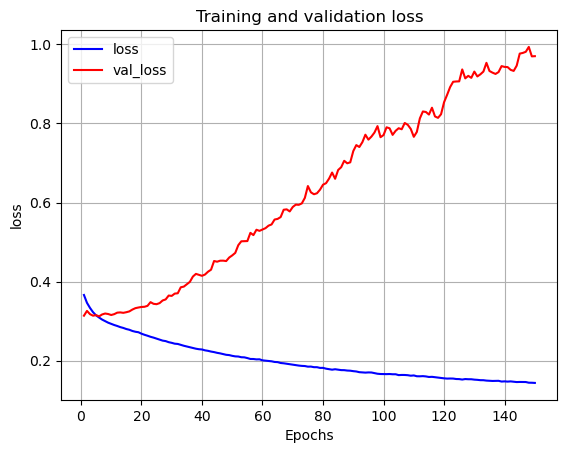

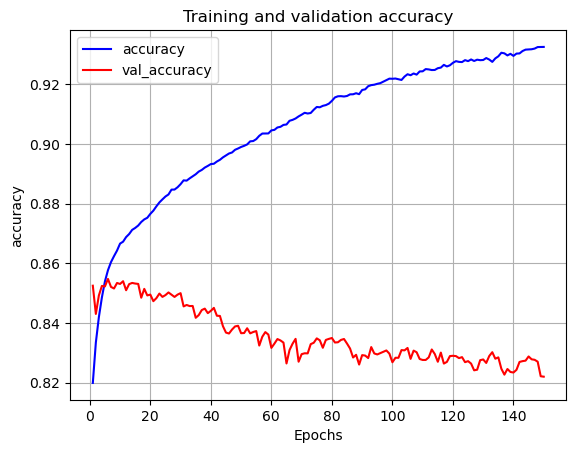

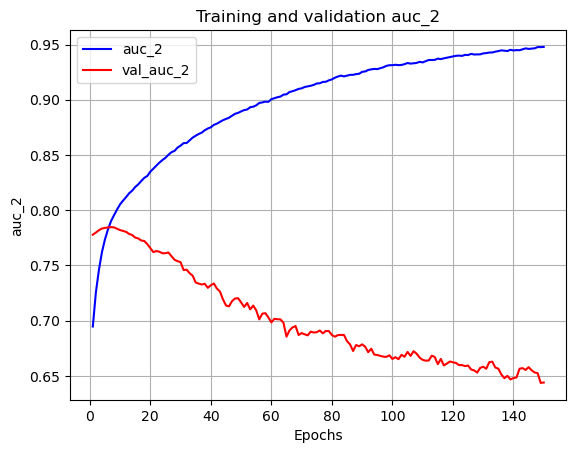

In [40]:
print("The optimum epochs number is: ", np.argmin(history4.history['val_loss'])+1, "epochs")
print("The minimum validation loss value is: ", min(history4.history['val_loss']))

# visualize the performance for each training and validation epochs
for i in range(3):
    performance_curve(history4, i)

We had built a NN model with one hidden layer, which overfitted data when the number of epochs increased. Next, we developed a model without hidden layers, which underfitted the data. Further, we built a deeper NN model with four hidden layers, which overfitted much earlier than the simple model. In the following part, we tuned the model to let it fit the data just right. 

### 1.4.5 Regularizing the model and hyper parameter tuning

#### 1.4.5.1 Define a hyper model 

In [41]:
# define a hyper model
def hyp_model(hp): 
    """
    Builds models based on instances of HyperParameters object 
    and defined hyperparameter space.
    
    Parameters
    ----------
    hp : HyperParameter object
    
    Returns
    -------
    model : keras model
            neuron network models built on HyperParameter object instances. 
    """
    
    # define hyperparameter space
    num_layers = hp.Int("num_layers", min_value = 3, max_value = 10, step = 1)    
    activation = hp.Choice("activation", ["relu", "tanh"])    
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")
    
    # Instantiate a NN model
    model = models.Sequential()
    
    for i in range(num_layers): 
        model.add(layers.Dense(
            units=hp.Int('units_'+str(i), min_value = 10, max_value = 400, step = 20), 
            activation=activation))  
        if dropout: 
            # assign dropout rates to dropout layer
            model.add(layers.Dropout(hp.Float("drop_rate_"+str(i), 0.2, 0.8, sampling='log'  )))
                
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    model.compile(optimizer = RMSprop(learning_rate = lr),
             loss = 'binary_crossentropy',
             metrics = ["accuracy", metrics.AUC(curve='PR')])
    
    return model

In [42]:
# instantiate BayesianOptimiser tuner
tuner = kt.BayesianOptimization(
    hypermodel = hyp_model, # The models built on HyperParameter object instances
    objective = kt.Objective("val_loss", direction="min"), # The name of the objective to optimize
    max_trials = 10,    
    overwrite = True, # Overwrite the previous results
    directory = "my_dir", # folder name under current working directory to store the serach result
    project_name = "Adult_BayesianOptimization", # Name of the sub-directory in the directory
)

In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 400, 'step': 20, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 400, 'step': 20, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 400, 'step': 20, 'sampling': None}


#### 1.4.5.2 Searching hyperparameter space

In [44]:
EARLY_STOPPING_PATIENCE = 5

es = EarlyStopping(
    monitor = "val_loss",
    patience = EARLY_STOPPING_PATIENCE,
    restore_best_weights = True
    )

In [45]:
tuner.search(
    X_train_sub, y_train_sub, 
    epochs = MAX_EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [es], 
    validation_data = (X_val, y_val)
    )

Trial 10 Complete [00h 00m 09s]
val_loss: 0.3152422606945038

Best val_loss So Far: 0.3032959997653961
Total elapsed time: 00h 03m 06s
INFO:tensorflow:Oracle triggered exit


In [46]:
tuner.results_summary()  

Results summary
Results in my_dir\Adult_BayesianOptimization
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
activation: tanh
dropout: False
lr: 0.0001
units_0: 390
units_1: 310
units_2: 10
drop_rate_0: 0.39158900205726305
drop_rate_1: 0.27808564151493037
drop_rate_2: 0.8
units_3: 310
drop_rate_3: 0.7792671725513467
units_4: 390
drop_rate_4: 0.581640426374632
units_5: 310
drop_rate_5: 0.8
units_6: 30
drop_rate_6: 0.6363327403663935
units_7: 10
drop_rate_7: 0.8
units_8: 10
drop_rate_8: 0.33030092707916753
Score: 0.3032959997653961
Trial summary
Hyperparameters:
num_layers: 3
activation: tanh
dropout: False
lr: 0.0007751276341014861
units_0: 390
units_1: 130
units_2: 170
drop_rate_0: 0.7183465826853779
drop_rate_1: 0.394921628524909
drop_rate_2: 0.2878993085405808
units_3: 110
drop_rate_3: 0.651121414835774
units_4: 390
drop_rate_4: 0.5286269241592327
units_5: 270
drop_rate_5: 0.8
units_6: 10
drop_rate_6: 0.23471951417275957
units_7: 210
drop_rate_7: 0.8
units_8: 30
d

In [47]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'num_layers': 3, 'activation': 'tanh', 'dropout': False, 'lr': 0.0001, 'units_0': 390, 'units_1': 310, 'units_2': 10, 'drop_rate_0': 0.39158900205726305, 'drop_rate_1': 0.27808564151493037, 'drop_rate_2': 0.8, 'units_3': 310, 'drop_rate_3': 0.7792671725513467, 'units_4': 390, 'drop_rate_4': 0.581640426374632, 'units_5': 310, 'drop_rate_5': 0.8, 'units_6': 30, 'drop_rate_6': 0.6363327403663935, 'units_7': 10, 'drop_rate_7': 0.8, 'units_8': 10, 'drop_rate_8': 0.33030092707916753}


Keras has many tuners that help us easily tune our model. We built a hyper model which allows the  BayesianOptimization Tuner to evaluate models' performances based on different hyperparameter combinations. The resulted best model contains three hidden layer as shown above. Then, we can build our optimal model based on the best hyperparameters.

### 1.4.6 Build the final model with optimal hyper parameters 

#### 1.4.6.1 Build the final model with optimum hyperparameters and epochs

In [48]:
final_model = tuner.hypermodel.build(best_hps)

#### 1.4.6.2 Tuning the epochs for the final model

In [49]:
history_final=final_model.fit(X_train_sub,y_train_sub, 
                                  epochs=300,
                                  batch_size = BATCH_SIZE,
                                  validation_data=[X_val, y_val])

Epoch 1/300
38/38 [==============================] - 1s 10ms/step - loss: 0.4260 - accuracy: 0.8069 - auc_1: 0.6372 - val_loss: 0.3622 - val_accuracy: 0.8383 - val_auc_1: 0.7153
Epoch 2/300
38/38 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.8399 - auc_1: 0.7328 - val_loss: 0.3411 - val_accuracy: 0.8449 - val_auc_1: 0.7432
Epoch 3/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3360 - accuracy: 0.8463 - auc_1: 0.7522 - val_loss: 0.3302 - val_accuracy: 0.8491 - val_auc_1: 0.7578
Epoch 4/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3288 - accuracy: 0.8492 - auc_1: 0.7617 - val_loss: 0.3266 - val_accuracy: 0.8515 - val_auc_1: 0.7650
Epoch 5/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3250 - accuracy: 0.8504 - auc_1: 0.7671 - val_loss: 0.3239 - val_accuracy: 0.8508 - val_auc_1: 0.7683
Epoch 6/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3225 - accuracy: 0.8515 - auc_1: 0.7694

38/38 [==============================] - 0s 7ms/step - loss: 0.3037 - accuracy: 0.8604 - auc_1: 0.7921 - val_loss: 0.3071 - val_accuracy: 0.8586 - val_auc_1: 0.7860
Epoch 48/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3034 - accuracy: 0.8605 - auc_1: 0.7925 - val_loss: 0.3063 - val_accuracy: 0.8572 - val_auc_1: 0.7872
Epoch 49/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3031 - accuracy: 0.8596 - auc_1: 0.7931 - val_loss: 0.3069 - val_accuracy: 0.8578 - val_auc_1: 0.7868
Epoch 50/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3029 - accuracy: 0.8595 - auc_1: 0.7930 - val_loss: 0.3066 - val_accuracy: 0.8573 - val_auc_1: 0.7870
Epoch 51/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3027 - accuracy: 0.8610 - auc_1: 0.7934 - val_loss: 0.3060 - val_accuracy: 0.8571 - val_auc_1: 0.7877
Epoch 52/300
38/38 [==============================] - 0s 7ms/step - loss: 0.3026 - accuracy: 0.8610 - auc_1: 0.7936 - val_l

Epoch 139/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2909 - accuracy: 0.8658 - auc_1: 0.8094 - val_loss: 0.3055 - val_accuracy: 0.8559 - val_auc_1: 0.7900
Epoch 140/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2906 - accuracy: 0.8667 - auc_1: 0.8102 - val_loss: 0.3037 - val_accuracy: 0.8612 - val_auc_1: 0.7900
Epoch 141/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2908 - accuracy: 0.8671 - auc_1: 0.8099 - val_loss: 0.3044 - val_accuracy: 0.8574 - val_auc_1: 0.7904
Epoch 142/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2906 - accuracy: 0.8672 - auc_1: 0.8103 - val_loss: 0.3034 - val_accuracy: 0.8608 - val_auc_1: 0.7907
Epoch 143/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2906 - accuracy: 0.8661 - auc_1: 0.8102 - val_loss: 0.3037 - val_accuracy: 0.8589 - val_auc_1: 0.7904
Epoch 144/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2905 - accuracy: 0.8674 - au

Epoch 185/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2860 - accuracy: 0.8692 - auc_1: 0.8168 - val_loss: 0.3038 - val_accuracy: 0.8594 - val_auc_1: 0.7912
Epoch 186/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2859 - accuracy: 0.8694 - auc_1: 0.8166 - val_loss: 0.3047 - val_accuracy: 0.8572 - val_auc_1: 0.7914
Epoch 187/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2857 - accuracy: 0.8689 - auc_1: 0.8168 - val_loss: 0.3047 - val_accuracy: 0.8580 - val_auc_1: 0.7909
Epoch 188/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2857 - accuracy: 0.8693 - auc_1: 0.8168 - val_loss: 0.3027 - val_accuracy: 0.8608 - val_auc_1: 0.7920
Epoch 189/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2856 - accuracy: 0.8685 - auc_1: 0.8170 - val_loss: 0.3031 - val_accuracy: 0.8611 - val_auc_1: 0.7917
Epoch 190/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2856 - accuracy: 0.8686 - au

Epoch 231/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2819 - accuracy: 0.8716 - auc_1: 0.8218 - val_loss: 0.3038 - val_accuracy: 0.8586 - val_auc_1: 0.7909
Epoch 232/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2816 - accuracy: 0.8711 - auc_1: 0.8224 - val_loss: 0.3032 - val_accuracy: 0.8606 - val_auc_1: 0.7912
Epoch 233/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2815 - accuracy: 0.8712 - auc_1: 0.8221 - val_loss: 0.3036 - val_accuracy: 0.8601 - val_auc_1: 0.7912
Epoch 234/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2815 - accuracy: 0.8709 - auc_1: 0.8220 - val_loss: 0.3041 - val_accuracy: 0.8576 - val_auc_1: 0.7904
Epoch 235/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2815 - accuracy: 0.8711 - auc_1: 0.8220 - val_loss: 0.3033 - val_accuracy: 0.8594 - val_auc_1: 0.7915
Epoch 236/300
38/38 [==============================] - 0s 8ms/step - loss: 0.2813 - accuracy: 0.8708 - au

Epoch 277/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2779 - accuracy: 0.8725 - auc_1: 0.8267 - val_loss: 0.3061 - val_accuracy: 0.8573 - val_auc_1: 0.7890
Epoch 278/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2776 - accuracy: 0.8739 - auc_1: 0.8269 - val_loss: 0.3058 - val_accuracy: 0.8560 - val_auc_1: 0.7890
Epoch 279/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2777 - accuracy: 0.8729 - auc_1: 0.8269 - val_loss: 0.3059 - val_accuracy: 0.8570 - val_auc_1: 0.7886
Epoch 280/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2774 - accuracy: 0.8731 - auc_1: 0.8274 - val_loss: 0.3048 - val_accuracy: 0.8589 - val_auc_1: 0.7895
Epoch 281/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2776 - accuracy: 0.8722 - auc_1: 0.8268 - val_loss: 0.3048 - val_accuracy: 0.8590 - val_auc_1: 0.7892
Epoch 282/300
38/38 [==============================] - 0s 7ms/step - loss: 0.2775 - accuracy: 0.8723 - au

The optimum epochs:  197 epochs
The minimum validation loss value is:  0.30265310406684875


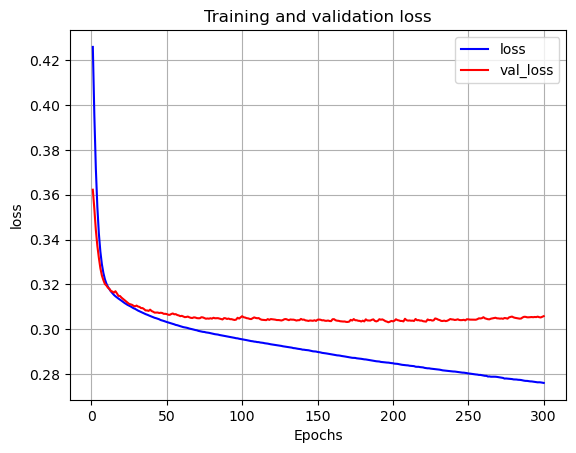

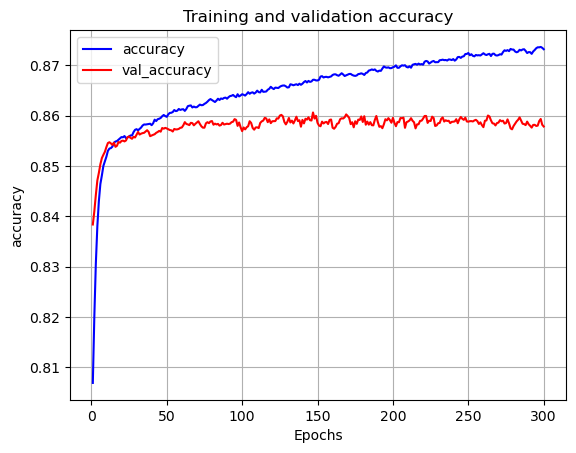

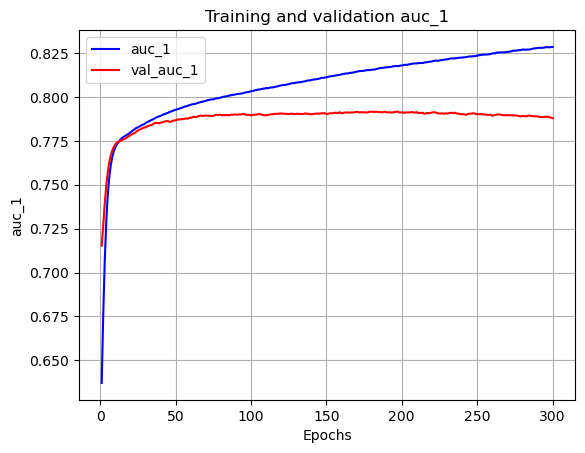

In [50]:
print("The optimum epochs: ", np.argmin(history_final.history['val_loss'])+1, "epochs")
print("The minimum validation loss value is: ", min(history_final.history['val_loss']))

# visualize the performance for each training and validation epochs
for i in range(3):
    performance_curve(history_final, i)

The final model validation performance slowly but consistently after the first several epochs. The minimum loss occurred around 200 epochs. The optimum model fits the data just right.

### 1.4.7 Final model evaluation

In [51]:
# train the final model based the whole training data

epochs = np.argmin(history_final.history['val_loss'])+1
final_model.fit(X_train, y_train, epochs = epochs, batch_size = BATCH_SIZE)

Epoch 1/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2850 - accuracy: 0.8690 - auc_1: 0.8158
Epoch 2/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2842 - accuracy: 0.8691 - auc_1: 0.8168
Epoch 3/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2840 - accuracy: 0.8697 - auc_1: 0.8168
Epoch 4/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2843 - accuracy: 0.8690 - auc_1: 0.8168
Epoch 5/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2838 - accuracy: 0.8688 - auc_1: 0.8174
Epoch 6/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2836 - accuracy: 0.8699 - auc_1: 0.8178
Epoch 7/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2835 - accuracy: 0.8700 - auc_1: 0.8179
Epoch 8/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2833 - accuracy: 0.8700 - auc_1: 0.8181
Epoch 9/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2831 

55/55 [==============================] - 0s 5ms/step - loss: 0.2707 - accuracy: 0.8768 - auc_1: 0.8333
Epoch 142/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2707 - accuracy: 0.8760 - auc_1: 0.8338
Epoch 143/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2706 - accuracy: 0.8765 - auc_1: 0.8338
Epoch 144/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2702 - accuracy: 0.8760 - auc_1: 0.8344
Epoch 145/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2703 - accuracy: 0.8759 - auc_1: 0.8341
Epoch 146/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2701 - accuracy: 0.8764 - auc_1: 0.8343
Epoch 147/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2699 - accuracy: 0.8767 - auc_1: 0.8347
Epoch 148/197
55/55 [==============================] - 0s 6ms/step - loss: 0.2701 - accuracy: 0.8766 - auc_1: 0.8343
Epoch 149/197
55/55 [==============================] - 0s 5ms/step - loss: 0.2

In [52]:
# evaluate model performance on both training and testing data sets
score_final_test = final_model.evaluate(X_test, y_test)
score_final_train = final_model.evaluate(X_train, y_train)

1018/1018 [==============================] - 1s 802us/step - loss: 0.2653 - accuracy: 0.8773 - auc_1: 0.8413


#### 1.4.7.1 Comparing evaluation result with simple models and the deep model

In [53]:
# train the simple model of 1 hidden layer based the whole training data

epochs1 = np.argmin(history1.history['val_loss'])+1
model1.fit(X_train, y_train, epochs = epochs1, batch_size = BATCH_SIZE)

# evaluate model performance on both training and testing data sets
score1_test = model1.evaluate(X_test, y_test)
score1_train = model1.evaluate(X_train, y_train)

Epoch 1/11
55/55 [==============================] - 0s 923us/step - loss: 0.2965 - accuracy: 0.8638 - auc: 0.7977
Epoch 2/11
55/55 [==============================] - 0s 1ms/step - loss: 0.2944 - accuracy: 0.8645 - auc: 0.8008
Epoch 3/11
55/55 [==============================] - 0s 635us/step - loss: 0.2939 - accuracy: 0.8660 - auc: 0.8009
Epoch 4/11
55/55 [==============================] - 0s 628us/step - loss: 0.2945 - accuracy: 0.8654 - auc: 0.8006
Epoch 5/11
55/55 [==============================] - 0s 609us/step - loss: 0.2936 - accuracy: 0.8653 - auc: 0.8020
Epoch 6/11
55/55 [==============================] - 0s 591us/step - loss: 0.2934 - accuracy: 0.8656 - auc: 0.8019
Epoch 7/11
55/55 [==============================] - 0s 591us/step - loss: 0.2932 - accuracy: 0.8657 - auc: 0.8020
Epoch 8/11
55/55 [==============================] - 0s 609us/step - loss: 0.2931 - accuracy: 0.8646 - auc: 0.8022
Epoch 9/11
55/55 [==============================] - 0s 609us/step - loss: 0.2928 - accurac

In [54]:
# train the simple model with 0 hidden layer based the whole training data
epochs0 = np.argmin(history0.history['val_loss'])+1
model0.fit(X_train, y_train, epochs = epochs0, batch_size = BATCH_SIZE)

# evaluate model performance on both training and testing data sets
score0_test = model0.evaluate(X_test, y_test)
score0_train = model0.evaluate(X_train, y_train)

Epoch 1/10
55/55 [==============================] - 0s 645us/step - loss: 0.3177 - accuracy: 0.8520 - auc_1: 0.7686
Epoch 2/10
55/55 [==============================] - 0s 978us/step - loss: 0.3173 - accuracy: 0.8529 - auc_1: 0.7692
Epoch 3/10
55/55 [==============================] - 0s 701us/step - loss: 0.3171 - accuracy: 0.8514 - auc_1: 0.7694
Epoch 4/10
55/55 [==============================] - 0s 529us/step - loss: 0.3175 - accuracy: 0.8526 - auc_1: 0.7689
Epoch 5/10
55/55 [==============================] - 0s 498us/step - loss: 0.3173 - accuracy: 0.8524 - auc_1: 0.7692
Epoch 6/10
55/55 [==============================] - 0s 517us/step - loss: 0.3173 - accuracy: 0.8526 - auc_1: 0.7692
Epoch 7/10
55/55 [==============================] - 0s 498us/step - loss: 0.3173 - accuracy: 0.8523 - auc_1: 0.7690
Epoch 8/10
55/55 [==============================] - 0s 535us/step - loss: 0.3173 - accuracy: 0.8521 - auc_1: 0.7693
Epoch 9/10
55/55 [==============================] - 0s 535us/step - loss

In [55]:
# train the deep model of 4 hidden layers based the whole training data
epochs4 = np.argmin(history4.history['val_loss'])+1
model4.fit(X_train, y_train, epochs = epochs4, batch_size = BATCH_SIZE)

# evaluate model performance on both training and testing data sets
score4_test = model4.evaluate(X_test, y_test)
score4_train = model4.evaluate(X_train, y_train)


Epoch 1/3
55/55 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.8913 - auc_2: 0.8450
Epoch 2/3
55/55 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.8928 - auc_2: 0.8601
Epoch 3/3
1018/1018 [==============================] - 0s 437us/step - loss: 0.2300 - accuracy: 0.8981 - auc_2: 0.8788


In [56]:
# create data frame to compair all performances
iterables = [["0 hidden layer", "1 hidden layer", "4 hidden layers", "optimum 3 layers"], ["test", "train"]]
index=pd.MultiIndex.from_product(iterables, names=["hidden layers", "dataset"])
performance = pd.DataFrame(data=[score0_test, score0_train, score1_test, score1_train,
                                 score4_test, score4_train, score_final_test, score_final_train],
                           index=index,
                          columns=['loss', 'accuracy', 'AUC(PR)'])


In [57]:
performance

loss  accuracy   AUC(PR)
hidden layers    dataset                              
0 hidden layer   test     0.319246  0.851351  0.761912
                 train    0.316380  0.853133  0.770928
1 hidden layer   test     0.317961  0.854115  0.765751
                 train    0.289044  0.868151  0.808028
4 hidden layers  test     0.421477  0.838022  0.696506
                 train    0.230010  0.898065  0.878816
optimum 3 layers test     0.312151  0.852088  0.779644
                 train    0.265290  0.877334  0.841253

In [58]:
print(best_hps.values)

{'num_layers': 3, 'activation': 'tanh', 'dropout': False, 'lr': 0.0001, 'units_0': 390, 'units_1': 310, 'units_2': 10, 'drop_rate_0': 0.39158900205726305, 'drop_rate_1': 0.27808564151493037, 'drop_rate_2': 0.8, 'units_3': 310, 'drop_rate_3': 0.7792671725513467, 'units_4': 390, 'drop_rate_4': 0.581640426374632, 'units_5': 310, 'drop_rate_5': 0.8, 'units_6': 30, 'drop_rate_6': 0.6363327403663935, 'units_7': 10, 'drop_rate_7': 0.8, 'units_8': 10, 'drop_rate_8': 0.33030092707916753}


Finally, we evaluated the performance on the optimum model. In addition, we evaluated the performances of all other models on test data set. The optimal model outperform the other models. Comparing with simple NN models, the difference in the performance is very minimum (less than 1% difference for loss and accuracy). We also evaluate all models' performances on the training data set. The results showed a trend that the less hidden layers, the closer performance between training and testing data sets. Comparing with the baseline model, the final results showed an estimated 9% improvement in accuracy and 40% improvement in the AUC curve.

## 1.5 Summary and conclusion

In this coursework, we explored whether different features of the adult dataset were informative to estimate a person's income level using NN models. Optimum model estimate over 85% accurately and over 77% AUC value, which suggests that the different features are informative in estimating people's income. However, the features may not be sufficiently informative to estimate income level. By evaluating performance on test dataset, we found the best accuracy is around 85% and AUC around 78%. Compared with the baseline model, the final results showed an estimated 9% improvement in accuracy and 40% improvement in the AUC curve, which may not be a satisfactory result. 

We set our baseline model by predicting every people's income level under 50k. The baseline model could achieve an accuracy of around 76% and AUC scores of around 38%. We started with a single hidden layer NN model and found the model overfits after several training epochs. By reducing and increasing the hidden layers, we found that a NN with no hidden layer may need more prediction power. In contrast, a four-hidden layer NN overfitted data quickly which suggest it is over capable and learned too many noise patterns just after several epochs. After tuning the model, we found that the optimum model could improve its performance along with time (more epochs), suggesting that the model has just the right capacity to learn.

By comparing all models' performances on test dataset, we found no significant difference among the three models, the optimum model and the simple models with zero or one hidden layer. The more complex the model, the higher the computation cost. In practice, we may choose the simpler model with no significant performance decrease. By comparing the performances between training and testing datasets, there are some noticeable different in performances, which could imply information leakage during training process. For instance, our data normalization was conducted on the whole training dataset, which may cause information leaking.

One limitation we need to address is the randomness in NN model. Randomness include random weight intialization, randomness in dropout regularization, randomness in Bayesian optimization. We adopted a random seed to make results reproducible. However, there are probabilities of different results, some may vary to a large extend. To capture generic performance of the models, it is recommendable to run models 30 times or more and take the average performance for each model. However, due to limited time and computational resources, we havn't done this step.

Overall, we achieved our goal to built a model that could efficiently estimate income level based on data. As the model has limited prediction power, or probably the data is not sufficiently informative, the final results should be understand with careful justification. Further studies could be carried out exploring different models and the predictability of such datasets. 

## 1.6 References


Chollet, F. (2017) *Deep learning with Python*. 1st edition. Shelter Island, NY: Manning Publications


University of London, (2023) *3.609 More epochs, validation log, plotting, smoothing* University of London, DSM150-2022-OCT, Topic 3: Getting started with neural networks (part 2), 3.609 More epochs, validation log, plotting,smoothing. [online]. Available at: https://learn.london.ac.uk/mod/page/view.php?id=96938 (Accessed: 02 January 2022)